## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
new_dir = 'split/'

train_folder = os.path.join(new_dir, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(new_dir, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(new_dir, 'validation')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [3]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(210, 210), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [4]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary')

validating data:
Found 792 images belonging to 2 classes.


In [5]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary') 

testing data:
Found 770 images belonging to 2 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))

In [8]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Designing CNN Model w/ L1 Regularization

Now it's time to design your CNN using Keras! Remember a few things when doing this: 

- You should alternate convolutional and pooling layers
- You should have later layers have a larger number of parameters in order to detect more abstract patterns
- Add some final dense layers to add a classifier to the convolutional base 
- Add L1 regularization to all four convolutional layers with 0.0000005 (5e-7) as the `lambda_coeff`
- Compile this model 

In [9]:
# Your code here; design and compile the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.0000005), input_shape=(210, 210, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.0000005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.0000005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.0000005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

## Training and Evaluating the Model

Remember that training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is apt to take hours to train on a high-end laptop. Using 30 epochs and 8 layers (alternating between convolutional and pooling), my model took about 14 hours to run on a 9 years old macbook pro (Late 2011, macOS High Sierra, v.10.13.6). That is, I set my model to run the training epochs overnight.  

In [11]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start = datetime.datetime.now()
print('program starts, current time:')
print(start)
history = model.fit(train_images, train_y, epochs=40, batch_size=100, validation_data=(val_images, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-11-22 22:00:20.884211
Epoch 1/40
47/47 [==============================] - 1501s 32s/step - loss: 0.5603 - accuracy: 0.7217 - val_loss: 0.5154 - val_accuracy: 0.7128
Epoch 2/40
47/47 [==============================] - 1458s 31s/step - loss: 0.4510 - accuracy: 0.7866 - val_loss: 0.3981 - val_accuracy: 0.8752
Epoch 3/40
47/47 [==============================] - 1433s 30s/step - loss: 0.3714 - accuracy: 0.8521 - val_loss: 0.3280 - val_accuracy: 0.8974
Epoch 4/40
47/47 [==============================] - 1457s 31s/step - loss: 0.3171 - accuracy: 0.8771 - val_loss: 0.2826 - val_accuracy: 0.9214
Epoch 5/40
47/47 [==============================] - 1613s 34s/step - loss: 0.2709 - accuracy: 0.9005 - val_loss: 0.3110 - val_accuracy: 0.8906
Epoch 6/40
47/47 [==============================] - 1499s 32s/step - loss: 0.2484 - accuracy: 0.9072 - val_loss: 0.2591 - val_accuracy: 0.9128
Epoch 7/40
47/47 [==============================] - 1745s 37s/step - loss: 0.2279 - a

## CNN Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [12]:
results_train = model.evaluate(train_images, train_y)

147/147 [==============================] - 359s 2s/step - loss: 0.0929 - accuracy: 0.9691


In [13]:
results_test = model.evaluate(test_images, test_y)

19/19 [==============================] - 50s 3s/step - loss: 0.0768 - accuracy: 0.9744


In [14]:
results_train

[0.09288771450519562, 0.9690501689910889]

In [15]:
results_test

[0.07684213668107986, 0.9743589758872986]

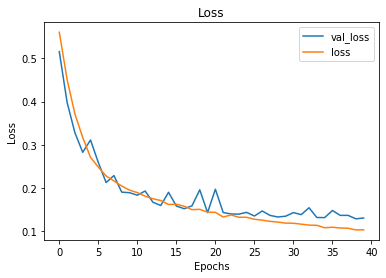

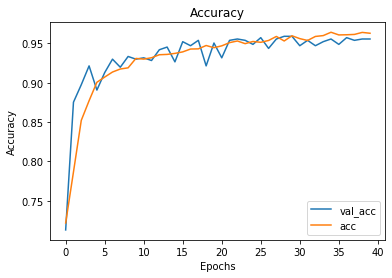

In [16]:
visualize_training_results(history)

In [17]:
preds_model = model.predict(test_images)

In [18]:
type(preds_model)

numpy.ndarray

In [19]:
preds_model.shape

(585, 1)

In [20]:
test_y.shape

(585, 1)

In [21]:
pred_model_class = model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
pred_model_class.shape

(585, 1)

In [23]:
pred_model_binary_class = (model.predict(test_images) > 0.5).astype("int32")
pred_model_binary_class.shape

(585, 1)

In [24]:
accuracy_model = accuracy_score(test_y, preds_model.round())
accuracy_model

0.9743589743589743

In [25]:
precision_model = precision_score(test_y, preds_model.round())
precision_model

0.9349112426035503

In [26]:
recall_model = recall_score(test_y, preds_model.round())
recall_model

0.9753086419753086

In [27]:
f1_model = f1_score(test_y, preds_model.round())
f1_model

0.9546827794561933

In [28]:
auc_value_model = roc_auc_score(test_y, preds_model)
auc_value_model

0.996643609724776

In [29]:
# test set
true_classes_vgg19 = test_generator.classes
print(true_classes_vgg19)
class_labels_vgg19 = list(test_generator.class_indices.keys())
class_labels_vgg19

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [30]:
fpr_model, tpr_model, threshold_model = roc_curve(test_y, preds_model)

In [31]:
roc_auc_model = auc(fpr_model, tpr_model)

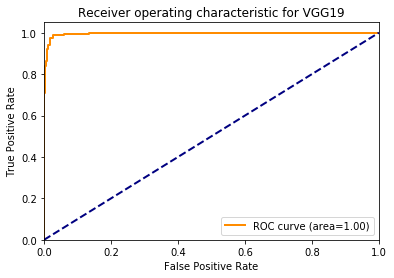

In [32]:
plt.figure()
lw=2
plt.plot(fpr_model, tpr_model, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_model)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for VGG19')
plt.legend(loc='lower right')
plt.show()

In [33]:
report_model = classification_report(test_y, preds_model.round())
print(report_model)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       423
         1.0       0.93      0.98      0.95       162

    accuracy                           0.97       585
   macro avg       0.96      0.97      0.97       585
weighted avg       0.98      0.97      0.97       585



In [34]:
cnf_matrix_model = confusion_matrix(y_true=test_y, y_pred=preds_model.round())
np.set_printoptions(precision=2)
print(cnf_matrix_model)

[[412  11]
 [  4 158]]


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[412  11]
 [  4 158]]


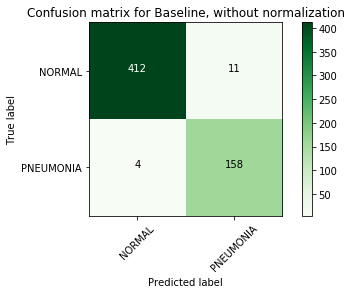

In [37]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


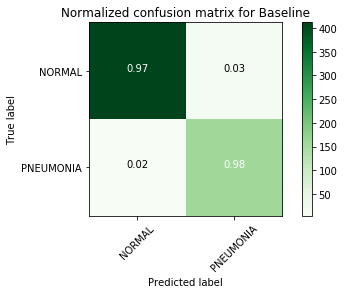

In [38]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

## Saving CNN Model

In [39]:
# Your code here; save the model for future reference 
model.save('cnn1_chest_xray_ALL_data_L1reg_'+str(date.today())+'.h5')

## Saving history in CSV

In [40]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data_L1reg'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)